# Assignment2
Repository Link: [Github](https://github.com/awakn123/CS6120NLP/tree/main)

Members: Yun Cao, Yue Liu, Nan Chen, Muyang Cheng

# Part 1: Data Preprocessing:
1.1 Load the dataset and perform initial exploration to understand its structure.

In [7]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('News_Category_Dataset_v3.csv')

print(df.head())

   Unnamed: 0                                           headline   category  \
0           0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1           1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2           2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3           3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4           4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

         date  headline_length  short_description_length

1.2 Clean the text data, including removing special characters, stopwords, applying lowercasing, correcting spelling, standardizing, handling contractions, and lemtization.

In [8]:
from nltk.corpus import stopwords
import nltk
import re
from symspellpy import SymSpell, Verbosity
from nltk.stem import WordNetLemmatizer
import pkg_resources
import inflect
import contractions
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

def standardize_numbers(text):
    return ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])

def handle_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    text = str(text)
    # lowercase
    text = text.lower()
    # standardize
    text = standardize_numbers(text)
    # handle contractions
    text = handle_contractions(text)
    # correct typos
    words = text.split()
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        corrected_words.append(suggestions[0].term if suggestions else word)
    text = ' '.join(corrected_words)
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # rejoin words
    text = ' '.join(words)
    return text

# clean data
df['cleaned_headline'] = df['headline'].apply(clean_text)
df['cleaned_description'] = df['short_description'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nanchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nanchen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1.3 Perform text tokenization and vectorization using TF-IDF.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

tfidf_vectorizer = TfidfVectorizer()

tfidf_headline = tfidf_vectorizer.fit_transform(df['cleaned_headline'])
# df_headline_tfidf = pd.DataFrame(tfidf_headline.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# df_headline_tfidf = df_headline_tfidf.add_prefix('headline_')

tfidf_description = tfidf_vectorizer.fit_transform(df['cleaned_description'])
# df_description_tfidf = pd.DataFrame(tfidf_description.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# df_description_tfidf = df_description_tfidf.add_prefix('description_')

# df = pd.concat([df, df_headline_tfidf, df_description_tfidf], axis=1)
tfidf= hstack([tfidf_headline,tfidf_description])

1.4 Extract and analyze different features from the text that might be useful for classification, such as word count,
sentence length, n-grams, etc

In [10]:
#pip install category_encoders

from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder

# change date
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# word count
df['headline_word_count'] = df['headline'].apply(lambda x: len(str(x).split()))
df['description_word_count'] = df['short_description'].apply(lambda x: len(str(x).split()))

# encode authors using Binary encoding
encoder = BinaryEncoder(cols=['authors'], return_df=True)
df_encoded = encoder.fit_transform(df['authors'])
df_encoded_sparse = csr_matrix(df_encoded.values)

# drop extra columns
selected_columns = ['year', 'month', 'day', 'headline_length', 'short_description_length', 'headline_word_count', 'description_word_count' ]
new_df = df[selected_columns].copy()
# combine
original_data = hstack([csr_matrix(new_df), df_encoded_sparse,tfidf])

# encode category using label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category']) # use for Logistic Regression, Random Forest, and XGBoost

y_categorical = pd.get_dummies(df['category']) # use for Artificial Neural Network and Convolutional Neural Network 

print(y)
print(y_categorical)
print(original_data)

[35 35  5 ... 28 28 28]
         ARTS  ARTS & CULTURE  BLACK VOICES  BUSINESS  COLLEGE  COMEDY  CRIME  \
0       False           False         False     False    False   False  False   
1       False           False         False     False    False   False  False   
2       False           False         False     False    False    True  False   
3       False           False         False     False    False   False  False   
4       False           False         False     False    False   False  False   
...       ...             ...           ...       ...      ...     ...    ...   
209522  False           False         False     False    False   False  False   
209523  False           False         False     False    False   False  False   
209524  False           False         False     False    False   False  False   
209525  False           False         False     False    False   False  False   
209526  False           False         False     False    False   False  False   

   

In [11]:
# Dimensionality Reduction using TruncatedSVD (which is better for sparse matrix)
from sklearn.decomposition import TruncatedSVD
import numpy as np

n_components = 100
svd = TruncatedSVD(n_components=n_components)

reduced_data = svd.fit_transform(original_data)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_ratio = sum(svd.explained_variance_ratio_)
print(f"Cumulative explained variance ratio with {n_components} components: {cumulative_explained_variance_ratio:.4f}")


Cumulative explained variance ratio with 100 components: 0.9998


In [12]:
import umap.umap_ as umap

# Create an instance of the UMAP model
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1,  n_components=2, metric='euclidean')

# Fit the model to your TF-IDF data and transform the data
reduced_data_umap = reducer.fit_transform(original_data)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In this part, we did dimensionality reduction useing TruncatedSVD. We chose 100 as n_components and get 99.98% cumulative explained variance ratio which effectively reduces the dimensionality of the data while retaining almost all of the information.

# Part 2: Model Implementation and Evaluation

For simplicity, we define 2 functions below to support plot confusion matrix and roc curve.

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_test, pred, title):
	conf_matrix = confusion_matrix(y_test, pred)  # Use predictions_binary or the equivalent for your case
	plt.figure(figsize=(10, 7))
	sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Class1', 'Class2'], yticklabels=['Class1', 'Class2'])
	plt.xlabel('Predicted Labels')
	plt.ylabel('True Labels')
	plt.title(title)
	plt.show()
	print(conf_matrix)

# ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_scores, title):
	# Assuming you have n_classes classes
	n_classes = len(np.unique(y_test))  # Make sure true_labels is your array of true labels

	true_labels_binarized = label_binarize(y_test, classes=range(n_classes))

	fpr = dict()
	tpr = dict()
	roc_auc = dict()

	for i in range(n_classes):
		fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], y_scores if y_scores.ndim == 1 else y_scores[:, i])
		roc_auc[i] = auc(fpr[i], tpr[i])

	plt.figure(figsize=(7, 7))
	colors = ['blue', 'red', 'green', 'purple', 'orange']
	for i, color in zip(range(n_classes), colors):
		plt.plot(fpr[i], tpr[i], color=color, lw=2,
						 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

	plt.plot([0, 1], [0, 1], 'k--', lw=2)
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title(title)
	plt.legend(loc="lower right")
	plt.show()

### Logistic Regression

In [17]:
#Logistic Regression: Use as a baseline model to understand the linear separability of text categories.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def perform_logistic(X, y):
	# Split the dataset into training and testing sets
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# Initialize the Logistic Regression model
	model = LogisticRegression(max_iter=1000)  # Increased iteration count to ensure convergence

	# Fit the model on the training data
	model.fit(X_train, y_train)

	# Make predictions on the test set
	y_pred = model.predict(X_test)
	return y_test, y_pred
	
def print_precision(y_test, y_pred):
	# Evaluate the model's performance
	accuracy = accuracy_score(y_test, y_pred)
	precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)  # Handling division by zero for classes with no predictions
	recall = recall_score(y_test, y_pred, average='weighted')
	f1 = f1_score(y_test, y_pred, average='weighted')

	# Print the evaluation metrics
	print(f"Accuracy: {accuracy}")
	print(f"Precision: {precision}")
	print(f"Recall: {recall}")
	print(f"F1 Score: {f1}")

Running with the original data, we get:

In [ ]:
# y_ori, p_ori = perform_logistic(original_data, y)
# print_precision(y_ori, p_ori)

```
Accuracy: 0.20939722235479405
Precision: 0.07310446519118276
Recall: 0.20939722235479405
F1 Score: 0.09615892807364297
```

Accuracy: The model correctly predicts 20.48%(max_iter=500)/20.93%(max_iter=1000) of the samples. This is a relatively low value, indicating that the model is not very good at correctly classifying data points in the test set overall.

Precision: The weighted average precision is 6.67%(max_iter=500)/7.31%(max_iter=1000). Precision refers to the proportion of samples predicted as positive that are actually positive. This very low value indicates that only a small fraction of the samples predicted by the model as positive are correct.

Recall: The weighted average recall is the same as accuracy, at 20.48%(max_iter=500)/20.93%(max_iter=1000). Recall calculates the proportion of samples that were predicted as positive and are actually positive out of all actual positive samples. This metric indicates the proportion of true positive samples the model is able to identify.

F1 Score: The weighted average F1 score is 8.64%(max_iter=500)/9.61%(max_iter=1000). The F1 score is the harmonic mean of precision and recall, trying to provide a balance between the two. A low F1 score indicates a lack of balance between precision and recall, with poor performance in both.

The result is not so good, and we try to proceed with the data reduced by PCA:

In [18]:
y_pca, p_pca = perform_logistic(reduced_data, y)
print_precision(y_pca, p_pca)

/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.21715267503460126
Precision: 0.09564257907152718
Recall: 0.21715267503460126
F1 Score: 0.11606034082880029


It runs faster, with only 8 minutes, however, the accuracy and other figures doesn't improve. 

There may be some key params I must find. I tried to run a RandomizedSearchCV:

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import ParameterSampler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from time import time, sleep

# # Define parameter space
# param_space = {
#     'C': np.logspace(-4, 4, 10),
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }

# # Generate a list of parameter combinations
# param_list = list(ParameterSampler(param_space, n_iter=10, random_state=42))

# # Split your data
# X_train, X_val, y_train, y_val = train_test_split(reduced_data, y, test_size=0.2, random_state=42, stratify=y)

# results = []
# start_overall = time()

# for i, params in enumerate(param_list, 1):
#     start = time()
    
#     # Initialize and fit the model
#     model = LogisticRegression(**params, max_iter=100)
#     model.fit(X_train, y_train)
    
#     # Predict and evaluate
#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
    
#     # Log results
#     elapsed = time() - start
#     print(f"Iteration {i}/{len(param_list)}: Accuracy={accuracy:.4f}, Time={elapsed:.2f}s, Params={params}")
    
#     results.append((accuracy, params, elapsed))
    
#     # Estimated time left
#     avg_time_per_iter = (time() - start_overall) / i
#     est_time_left = avg_time_per_iter * (len(param_list) - i)
#     print(f"Estimated time left: {est_time_left:.2f}s")

# # Convert results to DataFrame for easier analysis
# results_df = pd.DataFrame(results, columns=['Accuracy', 'Params', 'Time'])
# print("Best result:", results_df.loc[results_df['Accuracy'].idxmax()])

It runs over 4 hours and still kept running. I must try some other approaches:

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import ParameterSampler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from time import time, sleep

# # Define parameter space
# param_space = {
#     'C': np.logspace(-4, 4, 10),
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }

# # Generate a list of parameter combinations
# param_list = list(ParameterSampler(param_space, n_iter=10, random_state=42))

# # Split your data
# X_train, X_val, y_train, y_val = train_test_split(reduced_data, y, test_size=0.2, random_state=42, stratify=y)

# results = []
# start_overall = time()

# for i, params in enumerate(param_list, 1):
#     start = time()
    
#     # Initialize and fit the model
#     model = LogisticRegression(**params, max_iter=100)
#     model.fit(X_train, y_train)
    
#     # Predict and evaluate
#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred)
    
#     # Log results
#     elapsed = time() - start
#     print(f"Iteration {i}/{len(param_list)}: Accuracy={accuracy:.4f}, Time={elapsed:.2f}s, Params={params}")
    
#     results.append((accuracy, params, elapsed))
    
#     # Estimated time left
#     avg_time_per_iter = (time() - start_overall) / i
#     est_time_left = avg_time_per_iter * (len(param_list) - i)
#     print(f"Estimated time left: {est_time_left:.2f}s")

# # Convert results to DataFrame for easier analysis
# results_df = pd.DataFrame(results, columns=['Accuracy', 'Params', 'Time'])
# print("Best result:", results_df.loc[results_df['Accuracy'].idxmax()])



Reducing the iteration to 100 from 1000, I get the answer after 2.5 hours execution. Our param space is:
```
param_space = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
```
The best params are: 
```
{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.3593813663804626}
```

In the 3 parameters, the most important one is the solver 'liblinear'. With the 'saga' solver all accuracy are around '0.22'.

The second important factor is C. C is a regularization strength inverse. The accuracy would be above 0.4 when C is from 0.046415888336127774 to 21.54434690031882, but when C is around 0.00077 the accuracy drops to 0.22 too.

Not sure the difference of l1 and l2.

liblinear takes a long time than saga.

We applied above parameter into our model.

In [19]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_data, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(solver='liblinear', penalty='l1', C=0.3593813663804626, max_iter=100)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
print_precision(y_test, y_pred)

Accuracy: 0.4589080322626832
Precision: 0.4572080912875145
Recall: 0.4589080322626832
F1 Score: 0.4075888732963491


/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


It spends 47 minutes! A long time than I thought. No matter what, we now can get the confusion matrix and ROC curves.

Accuracy: 0.4589080322626832
Precision: 0.4572080912875145
Recall: 0.4589080322626832
F1 Score: 0.4075888732963491


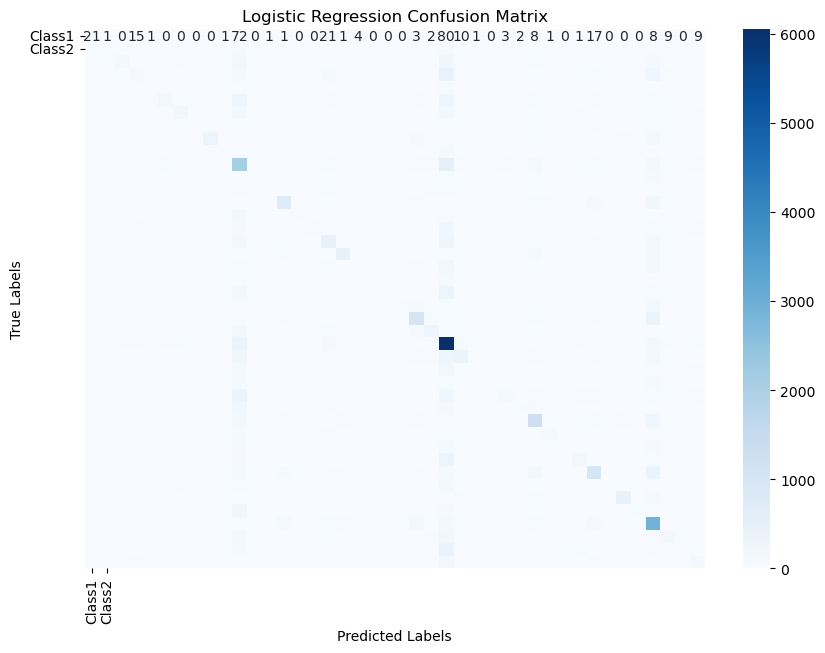

[[ 21   1   0 ...   9   0   9]
 [  0  68   2 ...   7   0   0]
 [  1   2 150 ...   9   1  24]
 ...
 [  0   2   3 ... 154   1  11]
 [  0   0   2 ...  10  18   0]
 [  4   0   3 ...   1   1 142]]


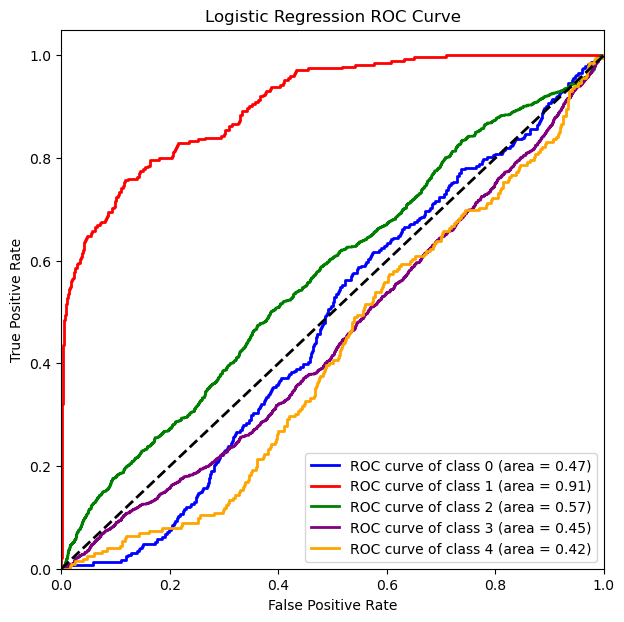

In [20]:
print_precision(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, "Logistic Regression Confusion Matrix")
y_scores = model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_scores, "Logistic Regression ROC Curve")

Seems logistic regression with liblinear could estimate the result in a reasonable way, but not so accurate and precise too. Most annoying during the process is the long and unpredictable time of the whole running process.

### Random Forest 
We use RandomizedSearchCV for hyperparameter tuning to find the best parameters for our model. RandomizedSearchCV performs an exhaustive search over the specified parameter grid, and best_params_ gives us the best parameters found during the search.
In this model, we also tune the following hyperparameter parameters. By choosing these parameters, we tune our Random Forest model to achieve the best performance.
we’ve chosen [10, 20] as possible values for n_estimators, which means the RandomizedSearchCV will try both 10 and 20 trees and see which one works better. We’ve chosen [None, 10] as possible values for max_depth, which means the RandomizedSearchCV will try both unlimited depth and a maximum depth of 10. min_samples_split is the minimum number of samples required to split an internal node.we’ve chosen [2, 5] as possible values, which means the RandomizedSearchCV will try splitting nodes with a minimum of 2 samples and a minimum of 5 samples. we’ve chosen [1, 2] as possible values for min_samples_leaf, which means the RandomizedSearchCV will try both a minimum of 1 sample and a minimum of 2 samples in a leaf node.
Cross-validation(cv) is the number of cross-validation folds to use, which estimates the performance of the model on unseen data. Scoring is the metric to use to evaluate the performance of your model. In this case, we’re using accuracy.The n_iter parameter in RandomizedSearchCV determines the number of parameter settings that are sampled. Randomized search is a way to save time compared to grid search, which tries every single combination of parameters. random_state is used for reproducibility. 

In [13]:


# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

X = reduced_data
y = df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_distributions = {
    'n_estimators': [10, 20],  # Number of trees in the forest
    'max_depth': [None, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
}

# Create a RandomForestClassifier
clf = RandomForestClassifier()

# Create the randomized search object
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, cv=3, scoring='accuracy', n_iter=5, random_state=42)

# Fit the randomized search object to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Train a new classifier using the best parameters
clf_best = RandomForestClassifier(**best_params)
clf_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf_best.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))


Accuracy: 0.5462702238342958
Precision: 0.5612219401511402
Recall: 0.5462702238342958
F1 Score: 0.5170098250544487


Visualize the results using confusion matrices for Random Forest model.

In [14]:
from IPython import get_ipython
ipython = get_ipython()

# This will disable the history
ipython.history_manager.enabled = False


#pip install seaborn

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import numpy as np

[[101   0   1 ...   3   0   3]
 [  0 139   2 ...   1   4   0]
 [  0   0 277 ...   5   6  14]
 ...
 [  3   0  14 ... 176   2   4]
 [  0   0  11 ...   4  62   0]
 [  3   0   0 ...   1   1 183]]


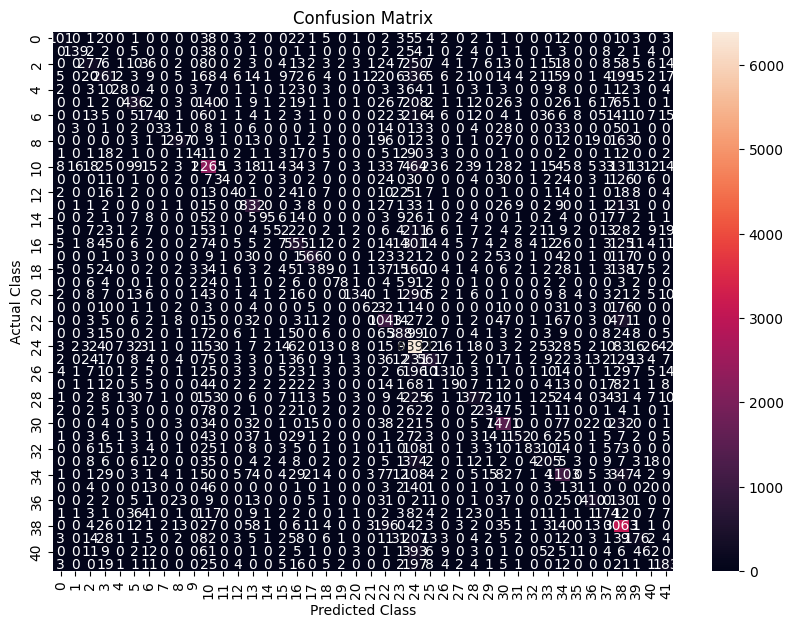

In [15]:

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


 To discuss the challenges encountered during the implementation, we create a DataFrame that contains the results of the randomized search, and then sort this DataFrame based on the rank of the test score.
 From these results, it appears that the model with 20 estimators, a minimum sample split of 5, a minimum sample leaf of 2, and a max depth of 100 had the highest average accuracy (mean_test_score of approximately 0.531) and ranked 1st (rank_test_score of 1). However, it’s worth noting that the differences in mean_test_score between the top-ranking models are quite small. Depending on the computational resources available and the importance of model interpretability, a simpler model (with fewer estimators or greater min_samples_split) might be preferable even if its performance is slightly worse.

In [16]:
results_df = pd.DataFrame(random_search.cv_results_)
sorted_results_df = results_df.sort_values(by='rank_test_score')
 
print(sorted_results_df)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2      32.857582      0.679452         0.339760        0.008428   
1      34.821260      0.415837         0.383804        0.008021   
0      17.460915      0.354591         0.219409        0.005701   
4      19.269715      0.218350         0.149187        0.001202   
3       9.521983      0.073015         0.094223        0.001664   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
2                 20                       2                      2   
1                 20                       2                      1   
0                 10                       2                      1   
4                 20                       2                      2   
3                 10                       5                      2   

  param_max_depth                                             params  \
2            None  {'n_estimators': 20, 'min_samples_split': 2, '...   
1            None  {'n_est

1. Overfitting: This is a common problem in machine learning where a model performs well on the training data but poorly on unseen data (like the test set). In the context of Random Forest, overfitting can occur if the trees are too complex, i.e., if they have too many levels (high max_depth) or if they are built using features that are not informative for the prediction task. Overfitting leads to a model that is too specific to the training data and fails to generalize to new data.
    ```
    param_distributions = {
        'max_depth': [1000],  # Maximum depth of the tree
    }
    ```
    ```
    Accuracy: 0.5535722808189758
    Precision: 0.5714115310401825
    Recall: 0.5535722808189758
    F1 Score: 0.5258374961025479
    ```
    ```
    param_distributions = {
        'max_depth': [10],  # Maximum depth of the tree
    }
    ```
    ```
    Accuracy: 0.4142843506896387
    Precision: 0.5898615940351453
    Recall: 0.4142843506896387
    F1 Score: 0.33017546312184437
    ```
    when it has high max_depth, the performance of the Random Forest model is better, but the running time is too long.

2. Underfitting: This is the opposite of overfitting. It occurs when the model is too simple to capture the underlying pattern of the data. In the context of Random Forest, underfitting can occur if the trees are too shallow (low max_depth) or if there are not enough trees in the forest (n_estimators is too low). Underfitting leads to a model that is too general and performs poorly on both the training and test data.
    ```
    param_distributions = {
        'n_estimators': [5],  # Number of trees in the forest
        'max_depth': [5],  # Maximum depth of the tree
    }
    ``` 
    ```
    Accuracy: 0.2892425905598244
    Precision: 0.2661950534137651
    Recall: 0.2892425905598244
    F1 Score: 0.1941654699291875
    ```
    ```
    param_distributions = {
        'n_estimators': [20],  # Number of trees in the forest
        'max_depth': [5],  # Maximum depth of the tree
    }
    ``` 
    ```
    Accuracy: 0.31129193910179925
    Precision: 0.3007321409531437
    Recall: 0.31129193910179925
    F1 Score: 0.20643591672868092
    ```
    when n_estimators and max_depth are relatively low, the running time is much shorter, however,  the accuracy, precision, recall, F1 score are much lower.

3. Model Tuning: The performance of the Random Forest model is heavily dependent on the hyperparameters chosen, such as n_estimators, max_depth, min_samples_split, and min_samples_leaf. Finding the right set of hyperparameters can be a challenging task. It requires a lot of computational resources and time, especially when the number of hyperparameters and the size of the search space is large. In your case, you used RandomizedSearchCV for hyperparameter tuning, which is a good choice when the search space is large, but it does not guarantee finding the optimal set of hyperparameters.
when parameter grid is
    ```
    param_distributions = {
        'n_estimators': [10, 20],  # Number of trees in the forest
        'max_depth': [None, 10],  # Maximum depth of the tree
        'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    }
    ```
    ```
    Accuracy: 0.5391829332315181
    Precision: 0.552339407017806
    Recall: 0.5391829332315181
    F1 Score: 0.5082750746600257. 
    ```
    The performance of the Random Forest model is relatively good and the running time is not too long.

### XGBoost

According to [XGBoost: Introduction to XGBoost Algorithm in Machine Learning](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost), it is a machine learning algorithm, utilizes the gradient boosting frameowrk, and would combine multiple individual models, often decision trees, to build an ensemble learning model.


In [10]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

def handle_xgboost(X, y):
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	X_train_csr = csr_matrix(X_train)
	X_test_csr = csr_matrix(X_test)

	dtrain = xgb.DMatrix(X_train_csr, label=y_train)
	dtest = xgb.DMatrix(X_test_csr, label=y_test)

	# Define your model parameters
	params = {
	    'objective': 'multi:softmax',  # Use 'binary:logistic' if you have two classes
	    'num_class': len(np.unique(y)),  # Needed for multi-class classification
			'tree_method': 'hist',  # Faster histogram optimized algorithm
	}
	evals = [(dtest, 'eval')]
	num_boost_round = 1000  # Set higher for early stopping
	early_stopping_rounds = 10

	# Train the model
	bst = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=early_stopping_rounds)

	# Make predictions
	predictions = bst.predict(dtest)
	return y_test, predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_precision(y_test, p):
	# Accuracy
	accuracy = accuracy_score(y_test, p)
	print(f"Accuracy: {accuracy}")

	# Precision
	precision = precision_score(y_test, p, average='macro')
	print(f"Precision: {precision}")

	# Recall
	recall = recall_score(y_test, p, average='macro')
	print(f"Recall: {recall}")

	# F1 Score
	f1 = f1_score(y_test, p, average='macro')
	print(f"F1 Score: {f1}")


During my processing period, the key difference is its effectiveness. It is too slow to run on the whole dataset, but also the parameter tuning. With default parameter and a tfidf dataset, the XGBoost model was running 74 minutes in my computer, but still not end. 

Think of previous assignment, dimension reduction maybe a good way. So we tried the PCA analysis. After running the model with a 100 features PCA result, we get the precision: 

In [11]:
y_pca, p_pca = handle_xgboost(reduced_data, y)
print_precision(y_pca, p_pca)

[0]	eval-mlogloss:2.53932
[1]	eval-mlogloss:2.31494
[2]	eval-mlogloss:2.18201
[3]	eval-mlogloss:2.07980
[4]	eval-mlogloss:2.00260
[5]	eval-mlogloss:1.94247
[6]	eval-mlogloss:1.88936
[7]	eval-mlogloss:1.84409
[8]	eval-mlogloss:1.80734
[9]	eval-mlogloss:1.77630
[10]	eval-mlogloss:1.74668
[11]	eval-mlogloss:1.71990
[12]	eval-mlogloss:1.69829
[13]	eval-mlogloss:1.67718
[14]	eval-mlogloss:1.65900
[15]	eval-mlogloss:1.64274
[16]	eval-mlogloss:1.62754
[17]	eval-mlogloss:1.61473
[18]	eval-mlogloss:1.60063
[19]	eval-mlogloss:1.58739
[20]	eval-mlogloss:1.57514
[21]	eval-mlogloss:1.56463
[22]	eval-mlogloss:1.55529
[23]	eval-mlogloss:1.54719
[24]	eval-mlogloss:1.53827
[25]	eval-mlogloss:1.53033
[26]	eval-mlogloss:1.52159
[27]	eval-mlogloss:1.51475
[28]	eval-mlogloss:1.50873
[29]	eval-mlogloss:1.50292
[30]	eval-mlogloss:1.49631
[31]	eval-mlogloss:1.49014
[32]	eval-mlogloss:1.48387
[33]	eval-mlogloss:1.47869
[34]	eval-mlogloss:1.47401
[35]	eval-mlogloss:1.46984
[36]	eval-mlogloss:1.46576
[37]	eval-m

It seems not so well but can be updated, and it takes 3.5 minutes. But I hope to reduce more and make it within 1 minutes.

So I tried to reduce the train model size. With a 0.98 test size, which means only use 0.02, nearly 4,000 rows to train the model, the time is only 14s. However, the result is 

```
Accuracy: 0.4427404705435455
Precision: 0.41335755375629696
Recall: 0.25124844089816784
F1 Score: 0.2880839218375771
```

It is not so good. I think the amount is too less and make the whole model underfit. 


Then we tried the UMAP to reduce the whole dataset to 2d. The efficiency improves greatly, we only need 17s to run the whole dataset. However, the precision is not so good: 

In [12]:
y_umap, p_umap = handle_xgboost(reduced_data_umap, y)
print_precision(y_umap, p_umap)

[0]	eval-mlogloss:3.32533
[1]	eval-mlogloss:3.21026
[2]	eval-mlogloss:3.13603
[3]	eval-mlogloss:3.08427
[4]	eval-mlogloss:3.04628
[5]	eval-mlogloss:3.01810
[6]	eval-mlogloss:2.99666
[7]	eval-mlogloss:2.98003
[8]	eval-mlogloss:2.96743
[9]	eval-mlogloss:2.95755
[10]	eval-mlogloss:2.94974
[11]	eval-mlogloss:2.94366
[12]	eval-mlogloss:2.93885
[13]	eval-mlogloss:2.93494
[14]	eval-mlogloss:2.93190
[15]	eval-mlogloss:2.92957
[16]	eval-mlogloss:2.92784
[17]	eval-mlogloss:2.92646
[18]	eval-mlogloss:2.92557
[19]	eval-mlogloss:2.92492
[20]	eval-mlogloss:2.92432
[21]	eval-mlogloss:2.92369
[22]	eval-mlogloss:2.92360
[23]	eval-mlogloss:2.92341
[24]	eval-mlogloss:2.92331
[25]	eval-mlogloss:2.92349
[26]	eval-mlogloss:2.92369
[27]	eval-mlogloss:2.92386
[28]	eval-mlogloss:2.92402
[29]	eval-mlogloss:2.92413
[30]	eval-mlogloss:2.92416
[31]	eval-mlogloss:2.92438
[32]	eval-mlogloss:2.92459
[33]	eval-mlogloss:2.92488
Accuracy: 0.23046819071254712
Precision: 0.07613124386198386
Recall: 0.05861788416999719
F1 

/Users/caoyun/miniconda3/envs/CS6120/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It is worse than only use 2% data. Tthe UMAP ignores too many features.

After studying, I found that the stratify sample may be a good way to find a good parameter. And for avoiding the computing burdern of all parameter combination, we decided only consider this 2 kinds of parameters: `max_depth` and `reg_lambda`.

```
param_grid = {
    'max_depth': [3, 5, 7],
    'reg_lambda': [1, 10]
}
```

In [13]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from xgboost import XGBClassifier

# # Assuming X, y represent your full dataset
# # Select a random subset
# X_subset, X_val, y_subset, y_val = train_test_split(reduced_data, y, test_size=0.9, stratify=y, random_state=42)

# # Define your model and parameter grid
# model = XGBClassifier()
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'reg_lambda': [1, 10],
# }

# # Perform grid search on the subset
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_subset, y_subset)

# # Sorting the results by the mean test score in descending order
# results_df = pd.DataFrame(grid_search.cv_results_)
# sorted_results_df = results_df.sort_values(by='rank_test_score')

# print(sorted_results_df)

After 1 hour running, We found max_depth =7 and reg_lambda = 10 is the best, but the time is so long that I cannot run other parameters. We would run XGBoost model with this parameter.

In [14]:
X = reduced_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_csr = csr_matrix(X_train)
X_test_csr = csr_matrix(X_test)

dtrain = xgb.DMatrix(X_train_csr, label=y_train)
dtest = xgb.DMatrix(X_test_csr, label=y_test)

# Define your model parameters
params = {
    'objective': 'multi:softprob',  # Use 'binary:logistic' if you have two classes
    'num_class': len(np.unique(y)),  # Needed for multi-class classification
		'tree_method': 'hist',  # Faster histogram optimized algorithm
		'max_depth': 7,
		'reg_lambda': 10
}
evals = [(dtest, 'eval')]
num_boost_round = 1000  # Set higher for early stopping
early_stopping_rounds = 10

# Train the model
bst = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=early_stopping_rounds)

# Make predictions
predictions = bst.predict(dtest)

[0]	eval-mlogloss:2.59665
[1]	eval-mlogloss:2.37892
[2]	eval-mlogloss:2.22981
[3]	eval-mlogloss:2.11683
[4]	eval-mlogloss:2.03308
[5]	eval-mlogloss:1.96018
[6]	eval-mlogloss:1.89989
[7]	eval-mlogloss:1.85252
[8]	eval-mlogloss:1.80490
[9]	eval-mlogloss:1.76891
[10]	eval-mlogloss:1.73641
[11]	eval-mlogloss:1.70844
[12]	eval-mlogloss:1.68469
[13]	eval-mlogloss:1.66317
[14]	eval-mlogloss:1.64196
[15]	eval-mlogloss:1.62334
[16]	eval-mlogloss:1.60645
[17]	eval-mlogloss:1.59027
[18]	eval-mlogloss:1.57848
[19]	eval-mlogloss:1.56662
[20]	eval-mlogloss:1.55492
[21]	eval-mlogloss:1.54064
[22]	eval-mlogloss:1.53013
[23]	eval-mlogloss:1.52045
[24]	eval-mlogloss:1.51093
[25]	eval-mlogloss:1.50200
[26]	eval-mlogloss:1.49471
[27]	eval-mlogloss:1.48635
[28]	eval-mlogloss:1.47956
[29]	eval-mlogloss:1.47237
[30]	eval-mlogloss:1.46634
[31]	eval-mlogloss:1.46137
[32]	eval-mlogloss:1.45516
[33]	eval-mlogloss:1.44877
[34]	eval-mlogloss:1.44393
[35]	eval-mlogloss:1.43935
[36]	eval-mlogloss:1.43417
[37]	eval-m


With above XGBoost model, we get the result, confusion matrix and ROC curves.

Accuracy: 0.6379277430439555
Precision: 0.6498026256241267
Recall: 0.49366089331364327
F1 Score: 0.5465016310245894


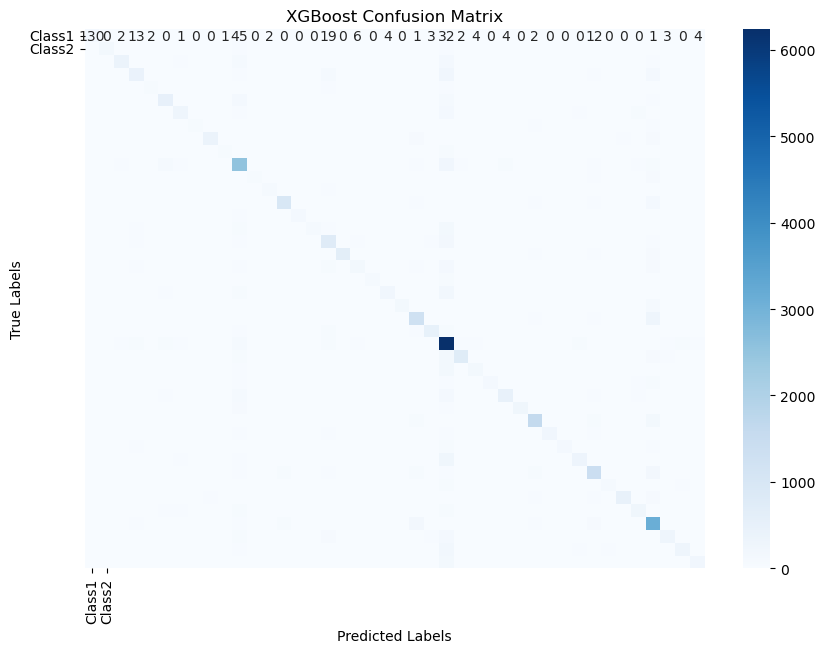

[[130   0   2 ...   3   0   4]
 [  0 159   1 ...   2   1   0]
 [  3   1 387 ...  11   5  10]
 ...
 [  2   0  14 ... 282   2   8]
 [  0   0   5 ...   6 272   1]
 [  4   0   3 ...   3   0 228]]


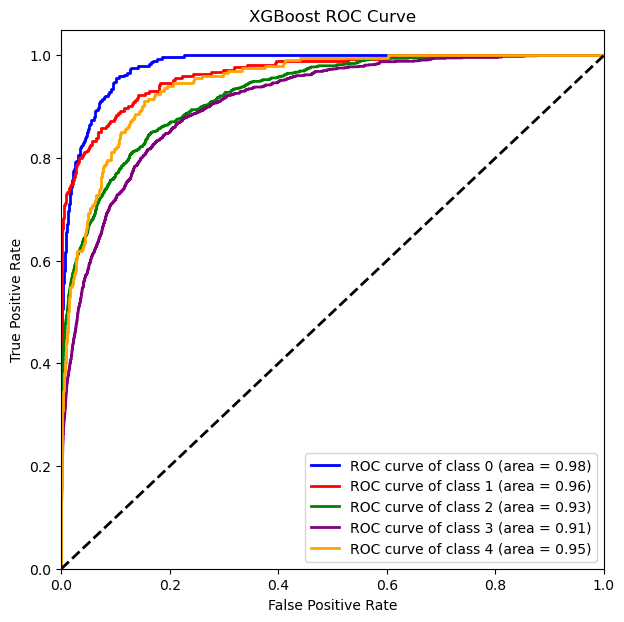

In [16]:
# Convert probability predictions to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)
print_precision(y_test, predicted_labels)
plot_confusion_matrix(y_test, predicted_labels, "XGBoost Confusion Matrix")
plot_roc_curve(y_test, predictions, "XGBoost ROC Curve")

It seems work well in ROC curve and confusion matrix, but the accuracy, precision, recall, and f1score are not so good. What I get is the model works well in some classes, but not so good in the precision part.

### Artificial Neural Network 

### Convolutional Neural Network 